In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# --- Read shapefile ---
shp_area = r"maps\concessions_SL\Concessions_SL_area_v1.shp"
gdf_area = gpd.read_file(shp_area)

# Ensure shapefile is in lat/lon
gdf_area = gdf_area.to_crs(epsg=4326)

In [3]:
# --- Load ---
path = "gnss/gnss_data.csv"
df = pd.read_csv(path)

# --- Parse + clean ---
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")
df = df.dropna(subset=["dates"])  # drop rows with bad dates

In [4]:
df.head()

,pnt_id,pnt_name,pnt_lat,pnt_lon,pnt_xrd,pnt_yrd,dates,n,e,u,sn,se,su
0,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2002-11-20,0.000426,0.007671,0.005879,0.000932,0.000673,0.002627
1,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-12,0.000447,-0.001009,-0.005334,0.000888,0.000654,0.002506
2,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-11,0.000381,0.000116,-0.005035,0.000889,0.000652,0.002511
3,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-10,0.000678,-0.001208,-0.006365,0.000893,0.000657,0.002522
4,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-09,-0.000864,-0.002044,-0.009819,0.000904,0.000663,0.002558


# Import inSAR

In [5]:
loc_asc = r'insar/sentinel1_asc_t088_limburg.csv'
loc_dsc = r'insar/sentinel1_dsc_t037_limburg.csv'

insar_asc_LOS = pd.read_csv(loc_asc, sep=',')
insar_dsc_LOS = pd.read_csv(loc_dsc, sep=',')

In [6]:
insar_asc_u = convert_insar_to_u(insar_asc_LOS)
insar_dsc_u = convert_insar_to_u(insar_dsc_LOS)

In [7]:
# # Extract the dates from the .csv file
insar_dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')
disp_asc_d = insar_asc_LOS.filter(regex='^d_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (insar_dates - insar_dates[0]).days
years = days/365

C:\Users\alami\AppData\Local\Temp\ipykernel_11624\2372800445.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


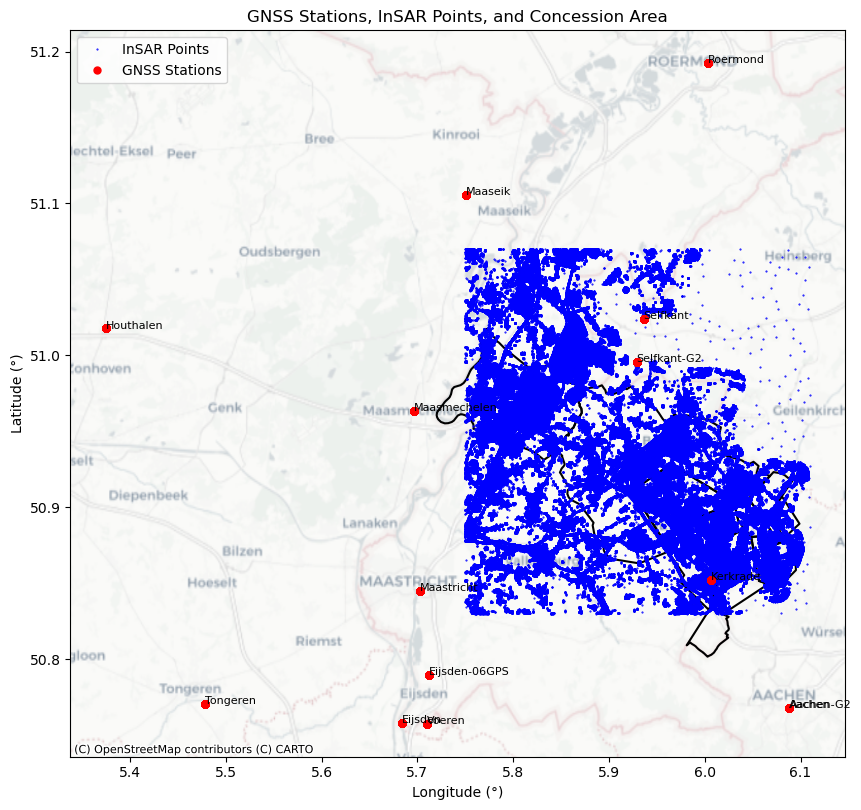

In [8]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
for name in df["pnt_name"].unique():
    subset = df[df["pnt_name"] == name]
    ax.text(
        subset["pnt_lon"].iloc[0],
        subset["pnt_lat"].iloc[0],
        name,
        fontsize=8,
        zorder=5
    )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

# station_name = "Kerkrade"
# buffer = 0.001

# st = df.loc[df["pnt_name"] == station_name].iloc[0]
# x0, y0 = st["pnt_lon"], st["pnt_lat"]

# xmin, xmax = x0 - buffer, x0 + buffer
# ymin, ymax = y0 - buffer, y0 + buffer

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


C:\Users\alami\AppData\Local\Temp\ipykernel_11624\2784325883.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


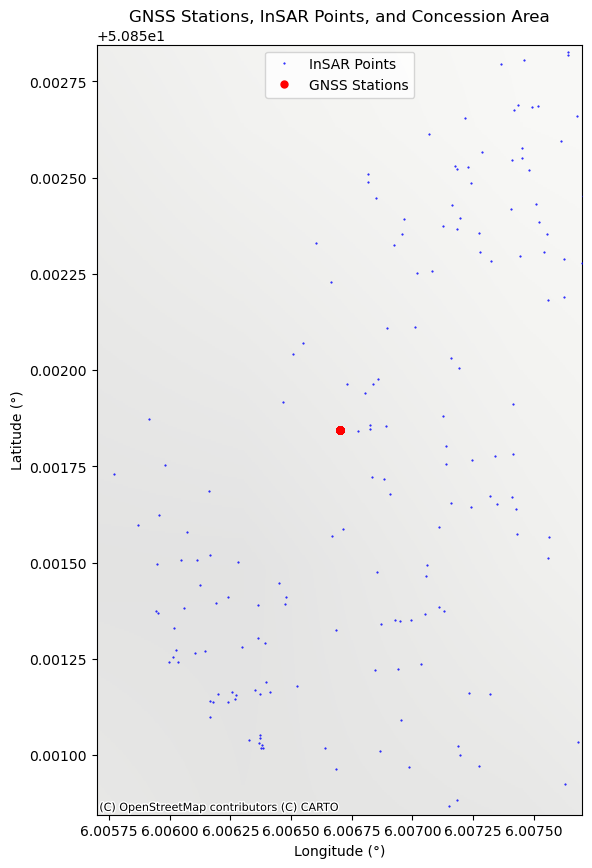

In [9]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
# for name in df["pnt_name"].unique():
#     subset = df[df["pnt_name"] == name]
#     ax.text(
#         subset["pnt_lon"].iloc[0],
#         subset["pnt_lat"].iloc[0],
#         name,
#         fontsize=8,
#         zorder=5
#     )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

station_name = "Kerkrade"
buffer = 0.001

st = df.loc[df["pnt_name"] == station_name].iloc[0]
x0, y0 = st["pnt_lon"], st["pnt_lat"]

xmin, xmax = x0 - buffer, x0 + buffer
ymin, ymax = y0 - buffer, y0 + buffer

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


In [10]:
def haversine_m(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in meters.
    Inputs can be scalars or numpy arrays.
    """
    R = 6371000.0  # Earth radius [m]
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def find_nearest_insar_points(insar_df, lat_0, lon_0, N=5,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Returns the N nearest InSAR points to (lat_0, lon_0) with distances in meters.
    """
    lat = insar_df[lat_col].to_numpy()
    lon = insar_df[lon_col].to_numpy()

    dist_m = haversine_m(lat_0, lon_0, lat, lon)
    nearest_idx = np.argsort(dist_m)[:N]

    out = insar_df.iloc[nearest_idx].copy()
    out["dist_m"] = dist_m[nearest_idx]
    return out.sort_values("dist_m")

In [31]:
station_name = 'Selfkant-G2'
lat_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lat'].values[0]
lon_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lon'].values[0]

print(f"{station_name} coordinates: lat={lat_0}, lon={lon_0}")


N = 50

# Use the DataFrame that still has metadata columns (pnt_lat/pnt_lon) + u_ columns.
# For example: insar_asc_u = add_vertical_insar(insar_asc) or convert_insar_to_u(insar_asc_LOS)
nearest = find_nearest_insar_points(insar_asc_u, lat_0, lon_0, N=N)

display(nearest[["pnt_id", "pnt_lat", "pnt_lon", "dist_m"]].head(N))

print(len(nearest))

Selfkant-G2 coordinates: lat=50.9955555555, lon=5.928888888888889


,pnt_id,pnt_lat,pnt_lon,dist_m
833107,L00013777P00029284,50.993368,5.927755,255.849700
832335,L00013776P00029285,50.993207,5.927437,280.202309
1072402,L00013811P00029357,50.997983,5.930451,291.264941
828680,L00013771P00029315,50.992845,5.929641,305.916380
828677,L00013771P00029306,50.992801,5.929112,306.654567
828679,L00013771P00029311,50.992814,5.929429,307.172546
828676,L00013771P00029305,50.992794,5.929066,307.280068
828682,L00013771P00029321,50.992836,5.929797,309.036809
828681,L00013771P00029316,50.992812,5.929660,309.813513
828678,L00013771P00029310,50.992774,5.929359,311.020114


50


In [32]:
def plot_gnss_insar_locations(insar_df, nearest_df, lat_0, lon_0,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Plot GNSS location and nearest InSAR points in lon-lat space.
    """
    plt.figure(figsize=(6, 6))

    # Nearest InSAR points
    plt.scatter(
        nearest_df[lon_col],
        nearest_df[lat_col],
        s=80,
        c="tab:blue",
        marker="o",
        label="Nearest InSAR points"
    )

    # GNSS station
    plt.scatter(
        lon_0,
        lat_0,
        s=120,
        c="red",
        marker="*",
        label="GNSS station"
    )

    # Annotate distances (optional but useful)
    for _, row in nearest_df.iterrows():
        plt.text(
            row[lon_col],
            row[lat_col],
            f"{row['dist_m']:.0f} m",
            fontsize=8,
            ha="left",
            va="bottom"
        )

    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.title("GNSS station and nearest InSAR points")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


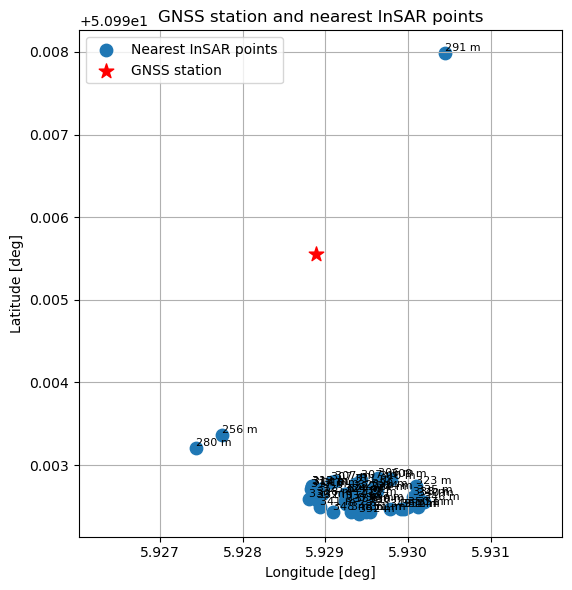

In [33]:
plot_gnss_insar_locations(
    insar_df=insar_asc_u,   # full InSAR DF with lat/lon
    nearest_df=nearest,     # output from find_nearest_insar_points
    lat_0=lat_0,
    lon_0=lon_0
)


In [34]:
# Extract displacement time series for nearest InSAR points
u_cols = insar_asc_u.filter(regex=r"^u_20").columns
disp_nearest_u = insar_asc_u.loc[nearest.index, u_cols]  # shape (N, n_times)

insar_mean_u = disp_nearest_u.mean(axis=0)  # Series indexed by u_YYYYMMDD columns
insar_mean_u = insar_mean_u.to_numpy()

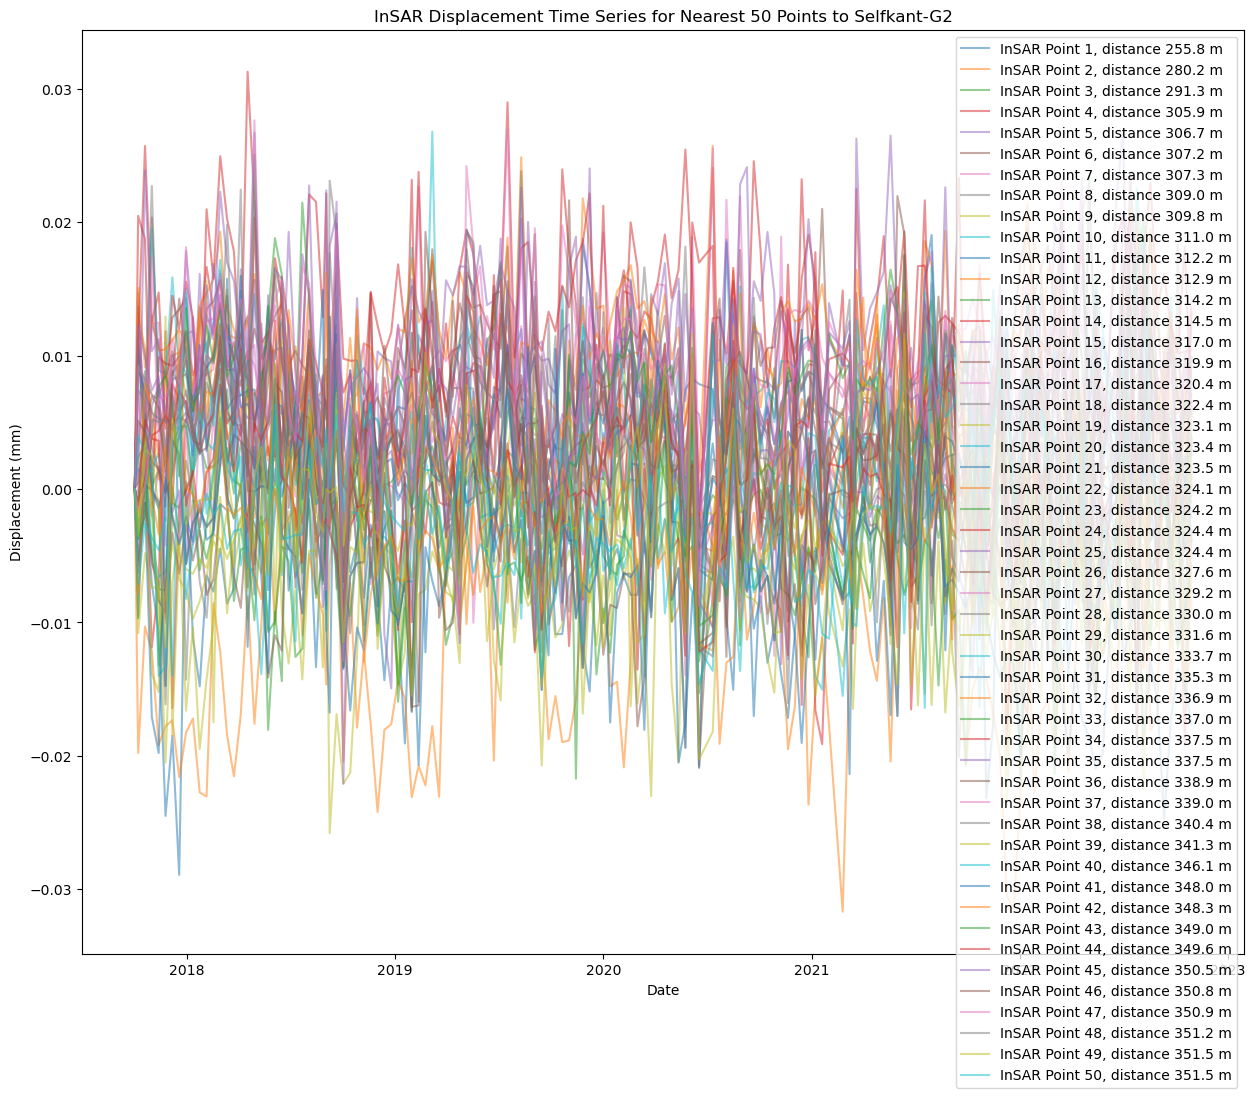

In [35]:
# Plot N nearest InSAR points and their mean
plt.figure(figsize=(15, 12))
for i in range(N):
    plt.plot(insar_dates, disp_nearest_u.iloc[i, :], label=f"InSAR Point {i+1}, distance {nearest.iloc[i]['dist_m']:.1f} m", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"InSAR Displacement Time Series for Nearest {N} Points to {station_name}")
plt.legend()
plt.show()


C:\Users\alami\AppData\Local\Temp\ipykernel_11624\3504764799.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


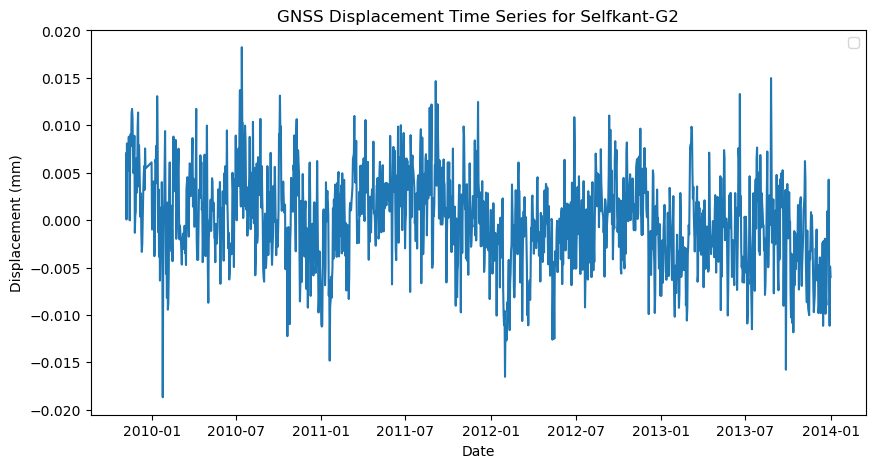

In [36]:
# Selfkant-G2 time series

series_selfkant = df[df["pnt_name"] == station_name].copy()
series_selfkant_sorted = series_selfkant.sort_values(by="dates")

gnss_dates = series_selfkant_sorted["dates"]
gnss_u = series_selfkant_sorted["u"].values

plt.figure(figsize=(10, 5))
plt.plot(gnss_dates, gnss_u)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series for {station_name}")
plt.legend()
plt.show()

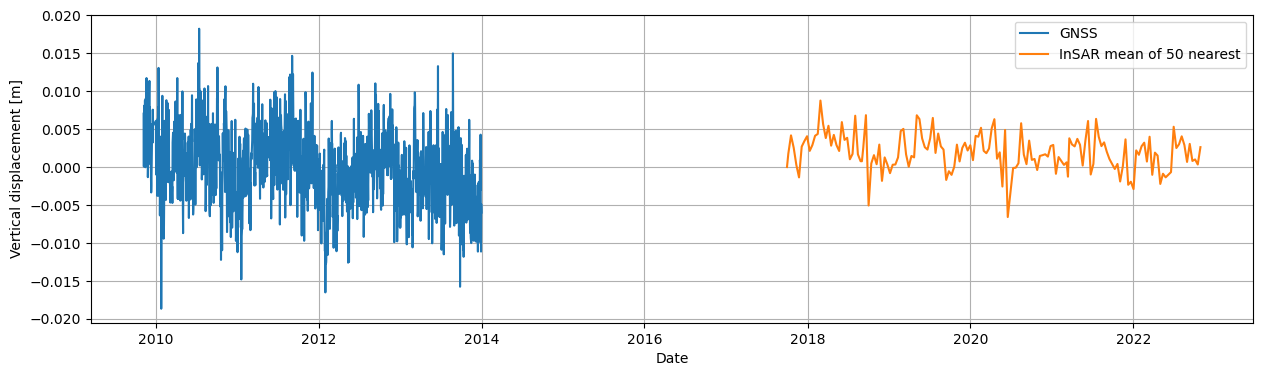

In [37]:
# Convert InSAR mean to numpy aligned with dates
plt.figure(figsize=(15,4))
plt.plot(gnss_dates, gnss_u, label="GNSS")
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()

# Fit linear trend model

In [38]:
gnss_t = (gnss_dates - gnss_dates.iloc[0]).dt.days.values
print(gnss_t)

insar_t = (insar_dates - gnss_dates.iloc[0]).days.values
print(insar_t)

t = np.arange(gnss_t[0], insar_t[-1] + 1)
print(t)

dates_full = gnss_dates.iloc[0] + pd.to_timedelta(t, unit='D')


[   0    1    2 ... 1513 1514 1515]
[2885 2891 2903 2915 2927 2939 2951 2963 2975 2987 2999 3011 3023 3035
 3047 3059 3071 3083 3095 3107 3119 3131 3143 3155 3167 3179 3191 3203
 3215 3221 3227 3239 3251 3263 3275 3287 3299 3311 3323 3335 3347 3359
 3371 3383 3395 3407 3419 3431 3443 3455 3467 3479 3491 3503 3515 3527
 3539 3551 3563 3575 3587 3599 3611 3623 3635 3647 3659 3671 3683 3695
 3707 3719 3731 3743 3755 3767 3779 3791 3803 3815 3827 3839 3851 3863
 3875 3899 3911 3923 3935 3947 3959 3971 3983 3995 4007 4019 4031 4043
 4055 4067 4079 4091 4103 4127 4139 4145 4151 4163 4175 4187 4199 4211
 4223 4235 4247 4259 4271 4283 4295 4307 4319 4331 4343 4355 4367 4379
 4391 4403 4415 4427 4439 4451 4463 4475 4487 4499 4511 4523 4535 4547
 4559 4571 4583 4607 4619 4631 4643 4655 4667 4679 4691 4703 4715 4727
 4739]
[   0    1    2 ... 4737 4738 4739]


In [39]:
def linear_trend(t, a, b):
    return a + b * t

popt_gnss, pcov_gnss = curve_fit(linear_trend, gnss_t, gnss_u)

a_gnss_hat, b_gnss_hat = popt_gnss
b_std = np.sqrt(pcov_gnss[1, 1])

print(f"Offset a gnss= {a_gnss_hat:.5f} m")
print(f"Velocity gnss= {b_gnss_hat*365.25:.5f} ± {b_std*365.25:.5f} m/year")


popt_insar, pcov_insar = curve_fit(linear_trend, insar_t, insar_mean_u)
a_insar_hat, b_insar_hat = popt_insar
b_insar_std = np.sqrt(pcov_insar[1, 1])
print(f"Offset a_insar = {a_insar_hat:.5f} m")
print(f"Velocity_insar = {b_insar_hat*365.25:.5f} ± {b_insar_std*365.25:.5f} m/year")

# Slope correction factor INSAR to align with GNSS

slope_correction = b_gnss_hat / b_insar_hat
print(f"Slope correction factor: {slope_correction:.5f}")

Offset a gnss= 0.00230 m
Velocity gnss= -0.00111 ± 0.00010 m/year
Offset a_insar = 0.00552 m
Velocity_insar = -0.00034 ± 0.00013 m/year
Slope correction factor: 3.25381


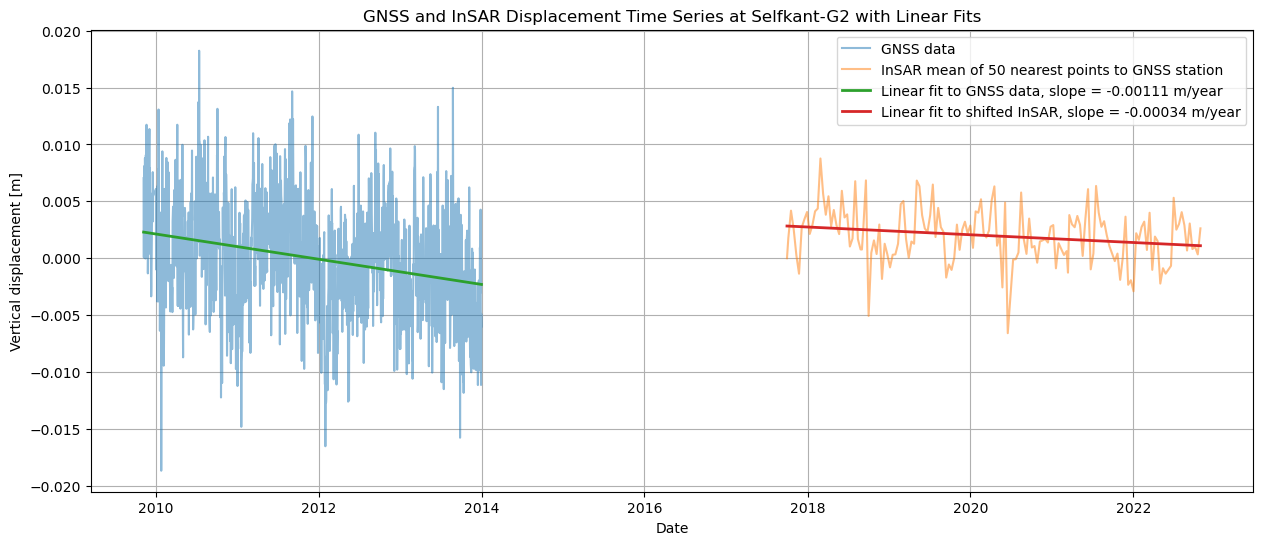

In [40]:
plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(gnss_dates, linear_trend(gnss_t, *popt_gnss), label=f"Linear fit to GNSS data, slope = {b_gnss_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, linear_trend(insar_t, *popt_insar), label=f"Linear fit to shifted InSAR, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Linear Fits")
plt.grid(True)
plt.legend()
plt.show()

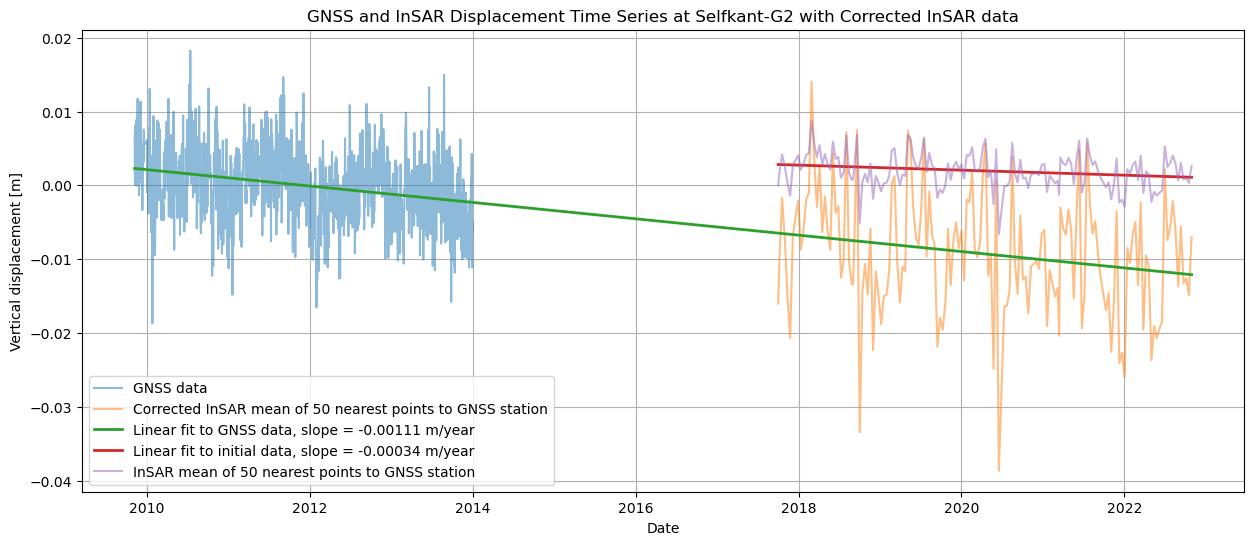

In [46]:
# Correcting the slope and shift  of the InSAR data to match GNSS
insar_mean_u_slope_corrected = insar_mean_u * slope_correction
shift_difference_mean_insar = np.abs(np.mean(linear_trend(insar_t, *popt_gnss) - insar_mean_u_slope_corrected))
insar_mean_u_final = insar_mean_u_slope_corrected - shift_difference_mean_insar
plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u_final, label=f"Corrected InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(dates_full, linear_trend(t, *popt_gnss), label=f"Linear fit to GNSS data, slope = {b_gnss_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, linear_trend(insar_t, *popt_insar), label=f"Linear fit to initial data, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Corrected InSAR data")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()



a_gnss = -3.4413716428229184e-06
b_gnss = 0.0026139586980719895
c_gnss = -0.0017956399024700084
d_gnss = 7.309716739511834e-05
 
a_insar = -1.0023984957480312e-06
b_insar = 0.00581293244517725
c_insar = -3.489468299214005e-05
d_insar = -0.0009024950316429322
Slope correction factor: 3.43314


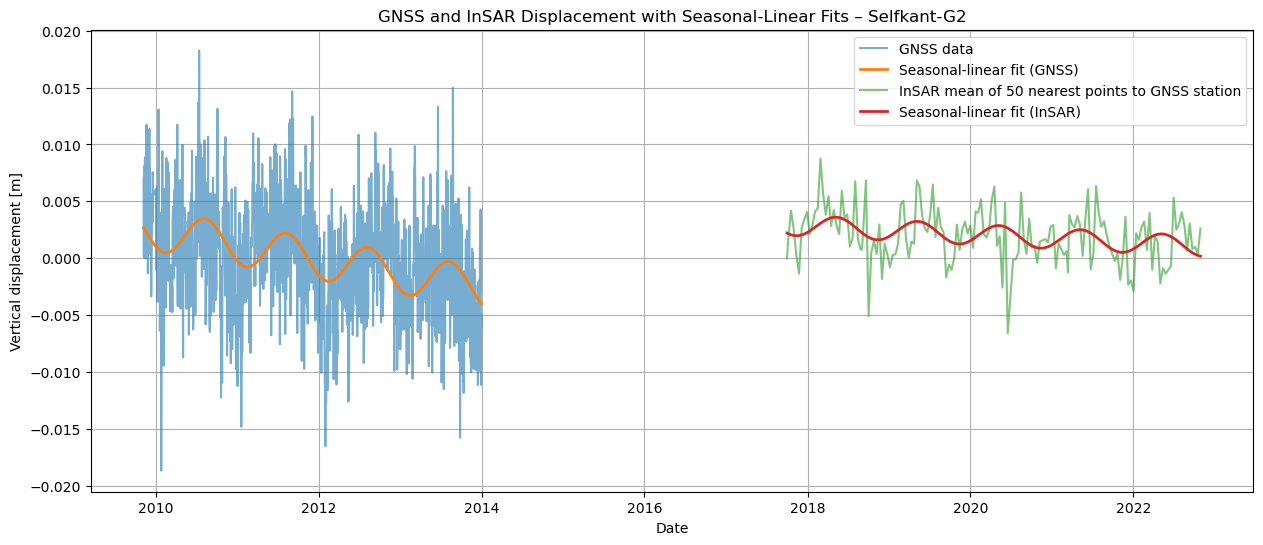

In [47]:
def seasonal_linear_trend(t, a, b, c, d):
     period = 365.25 
     return a * t + b + c * np.sin(2/period * np.pi * t ) + d * np.cos(2/period * np.pi * t)


params_gnss, _ = curve_fit(seasonal_linear_trend, gnss_t, gnss_u)
a_gnss, b_gnss, c_gnss, d_gnss = params_gnss

params_insar, _ = curve_fit(seasonal_linear_trend, insar_t, insar_mean_u)
a_insar, b_insar, c_insar, d_insar = params_insar

print('a_gnss =', a_gnss)
print('b_gnss =', b_gnss)
print('c_gnss =', c_gnss)
print('d_gnss =', d_gnss)
print(' ')
print('a_insar =', a_insar)
print('b_insar =', b_insar)
print('c_insar =', c_insar)
print('d_insar =', d_insar)

slope_correction = a_gnss / a_insar
print(f"Slope correction factor: {slope_correction:.5f}")


# Plot both datasets and the seasonal curves
plt.figure(figsize=(15, 6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.6, markersize=3)
plt.plot(gnss_dates, seasonal_linear_trend(gnss_t, *params_gnss), label="Seasonal-linear fit (GNSS)", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.6, markersize=3)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar), label="Seasonal-linear fit (InSAR)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Fits – {station_name}")
plt.legend()
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Fits – {station_name}")
plt.grid(True)
plt.show()


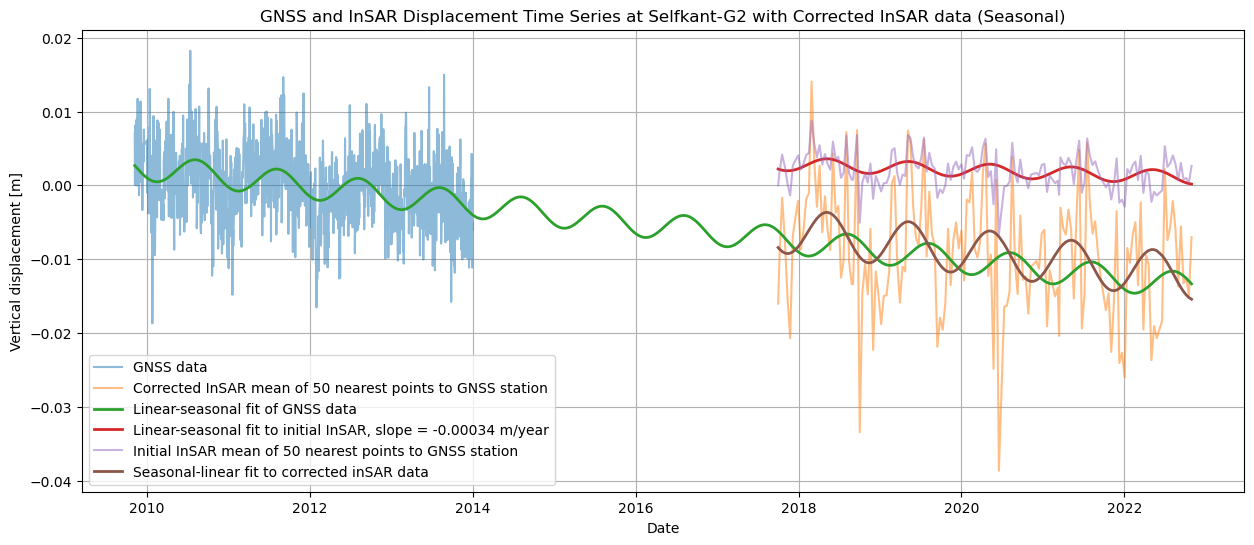

In [49]:
insar_mean_u_slope_corrected_seasonal = insar_mean_u * slope_correction
shift_difference_mean_insar_seasonal = np.abs(np.mean(linear_trend(insar_t, *popt_gnss) - insar_mean_u_slope_corrected_seasonal))
insar_mean_u_final_seasonal = insar_mean_u_slope_corrected_seasonal - shift_difference_mean_insar_seasonal

plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u_final_seasonal, label=f"Corrected InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(dates_full, seasonal_linear_trend(t, *params_gnss), label="Linear-seasonal fit of GNSS data", linewidth=2)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar), label=f"Linear-seasonal fit to initial InSAR, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"Initial InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar)*slope_correction - shift_difference_mean_insar_seasonal, label=f"Seasonal-linear fit to corrected inSAR data", linewidth=2)
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Corrected InSAR data (Seasonal)")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()


# Evalutation of fit

In [50]:
# RMSE Calculation

# Linear fit and seasonal fit to GNSS data
gnss_linear_fit = linear_trend(gnss_t, *popt_gnss)
gnss_seasonal_fit = seasonal_linear_trend(gnss_t, *params_gnss)

# Calculate RMSE for linear fit
rmse_linear_gnss = np.sqrt(np.mean((gnss_u - gnss_linear_fit) ** 2))
print(f"RMSE (Linear Fit): {rmse_linear_gnss:.5f} m")
# Calculate RMSE for seasonal fit
rmse_seasonal_gnss = np.sqrt(np.mean((gnss_u - gnss_seasonal_fit) ** 2))
print(f"RMSE (Seasonal Fit): {rmse_seasonal_gnss:.5f} m")    

# differnce in RMSE %
rmse_diff_percent = ((rmse_linear_gnss - rmse_seasonal_gnss) / rmse_seasonal_gnss) * 100
print(f"The linear RMSE is {rmse_diff_percent:.2f}% larger than the seasonal RMSE.")


RMSE (Linear Fit): 0.00465 m
RMSE (Seasonal Fit): 0.00448 m
The linear RMSE is 3.78% larger than the seasonal RMSE.


In [51]:
# RMSE Calculation

# Linear fit and seasonal-linear fit to inSAR data
insar_linear_fit = linear_trend(insar_t, *popt_insar)
insar_seasonal_fit = seasonal_linear_trend(insar_t, *params_insar)

# Calculate RMSE for linear fit
rmse_linear_insar = np.sqrt(np.mean((insar_mean_u - insar_linear_fit) ** 2))
print(f"RMSE InSAR (Linear Fit): {rmse_linear_insar:.5f} m")
# Calculate RMSE for seasonal fit
rmse_seasonal_insar = np.sqrt(np.mean((insar_mean_u - insar_seasonal_fit) ** 2))
print(f"RMSE InSAR (Seasonal Fit): {rmse_seasonal_insar:.5f} m")       

# differnce in RMSE %
rmse_diff_percent_insar = ((rmse_linear_insar - rmse_seasonal_insar) / rmse_seasonal_insar) * 100
print(f"The linear InSAR RMSE is {rmse_diff_percent_insar:.2f}% larger than the seasonal InSAR RMSE.")


RMSE InSAR (Linear Fit): 0.00233 m
RMSE InSAR (Seasonal Fit): 0.00224 m
The linear InSAR RMSE is 4.01% larger than the seasonal InSAR RMSE.
